**TASK 3: LOG-NORMAL HRTEM DATA** 

In [19]:
import pystan
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Load hrtem data: read the particle sizes (in nanometers) from a CSV file.
data_hrtem = np.loadtxt('hrtem.csv')
print('%i data_hrtem, min: %f, max: %f' % (len(data_hrtem), min(data_hrtem), max(data_hrtem)))

#Transform the data
log_data = np.log(data_hrtem)

500 data_hrtem, min: 1.051827, max: 28.942578


In [20]:
# Data for Stan model
hrtem = {
    'particle_sizes' : log_data,
    'count' : len(log_data),
    'mu' : 2.3,
    'nu' : 0.1,
    'alpha' : 2,
    'beta' : 5,
}


In [21]:
# Stan model
stan_code = """

data {
    int<lower=0> count;
    real<lower=0> particle_sizes[count];    
    real<lower=0> mu;
    real<lower=0> nu;
    real<lower=0> alpha;  
    real<lower=0> beta;   
   
}

parameters {
    real mu_mean;
    real<lower=0> sigma2;
}

transformed parameters {
    real<lower=0> sigma;
    sigma = sqrt(sigma2);
}

model {
    mu_mean ~ normal(mu,sqrt(sigma2/nu)); 
    sigma2 ~ inv_gamma(alpha,beta); 
    for (i in 1: count){
        particle_sizes[i] ~ normal(mu_mean,sqrt(sigma2));
    } 
}

"""

In [5]:
# Compile Stan model
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d9088c590618e3825a5f6433199fe42d NOW.


In [6]:
# Fit the model to the data
results = stan_model.sampling(data=hrtem)

# Extract the samples generated by Stan
samples = results.extract()

Posterior 95% confidence interval for the mean: [1.83016164 1.95649989]


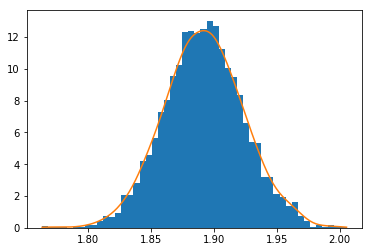

Posterior 95% confidence interval for the variance: [0.43860274 0.56271495]


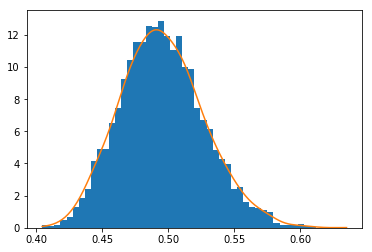

In [8]:
# Compute 95% posterior confidence intervals for the mean and the variance
mean_conf = np.percentile(samples['mu_mean'], [2.5, 97.5])
sigma2_conf = np.percentile(samples['sigma2'], [2.5, 97.5])

# Plot mean histogram
print("Posterior 95% confidence interval for the mean:", mean_conf)

plot1 = samples['mu_mean']
density = gaussian_kde(plot1)
xs = np.linspace(min(plot1), max(plot1), 200)
plt.hist(plot1, bins=50, density=True)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density(xs))
plt.show()

# Plot variance histogram
print("Posterior 95% confidence interval for the variance:", sigma2_conf)

plot2 = samples['sigma2']
density = gaussian_kde(plot2)
xs = np.linspace(min(plot2), max(plot2), 200)
plt.hist(plot2, bins=50, density=True)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density(xs))
plt.show()


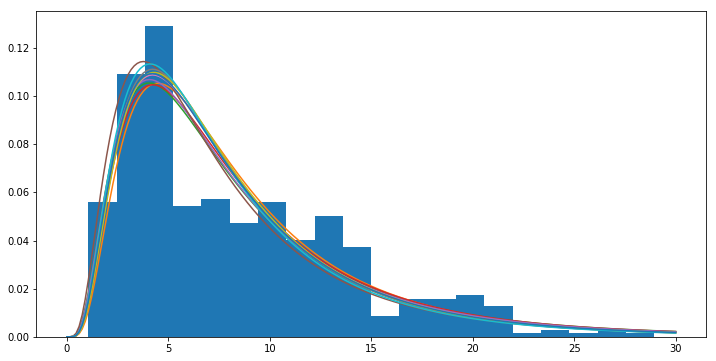

In [18]:
# Take random 10 samples
num_samples = 10
mean_10 = np.random.choice(samples['mu_mean'], num_samples)
variance_10 =  np.random.choice(samples['sigma2'], num_samples)

# Plot the log-normal distributions corresponding to the samples
plt.figure(figsize=(12,6))
plt.hist(data_hrtem, bins=20, density=True)
plot_x = np.linspace(0, 30, 200)
for i in range(num_samples):
    plot_y = stats.lognorm.pdf(plot_x, np.sqrt(variance_10[i]), scale=np.exp(mean_10[i]))
    plt.plot(plot_x, plot_y)
plt.show()
